# Промежуточная аттестация 4.  

## Распознавание ключевых точек лица в реальном времени  

Цель: Разработать приложение, которое обнаруживает ключевые точки лица  

(например, положение глаз, уголков рта и пр) в видеопотоке в реальном  

времени, используя предварительно обученную модель глубокого обучения из  

PyTorch и OpenCV для захвата кадров и отображения видео.  

In [8]:
!ls dataset_2

annotations.xml  collage  images  info_meta.csv


# Загрузка датасета

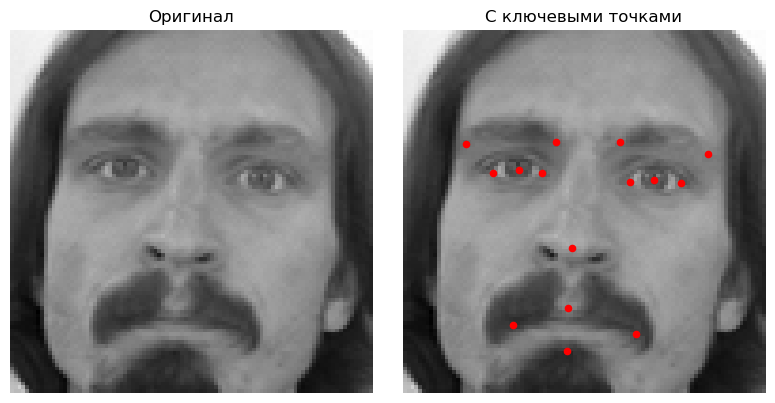

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def img_show(idx=0):
    # Загрузка данных
    df = pd.read_csv('dataset_2/training.csv')

    # Получаем строку с пикселями изображения
    image_str = df.loc[idx, 'Image']
    image_array = np.fromstring(image_str, sep=' ', dtype=np.uint8)
    image = image_array.reshape(96, 96)

    # Получаем координаты ключевых точек (если они есть)
    keypoints = []
    for col in df.columns:
        if col != 'Image' and not pd.isnull(df.loc[idx, col]):
            keypoints.append(float(df.loc[idx, col]))
    keypoints = np.array(keypoints).reshape(-1, 2) if len(keypoints) % 2 == 0 else None

    # Создаём фигуру с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Слева — просто изображение
    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Оригинал')
    axs[0].axis('off')

    # Справа — изображение с точками
    axs[1].imshow(image, cmap='gray')
    if keypoints is not None:
        axs[1].scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=20)
    axs[1].set_title('С ключевыми точками')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


img_show(idx=0)

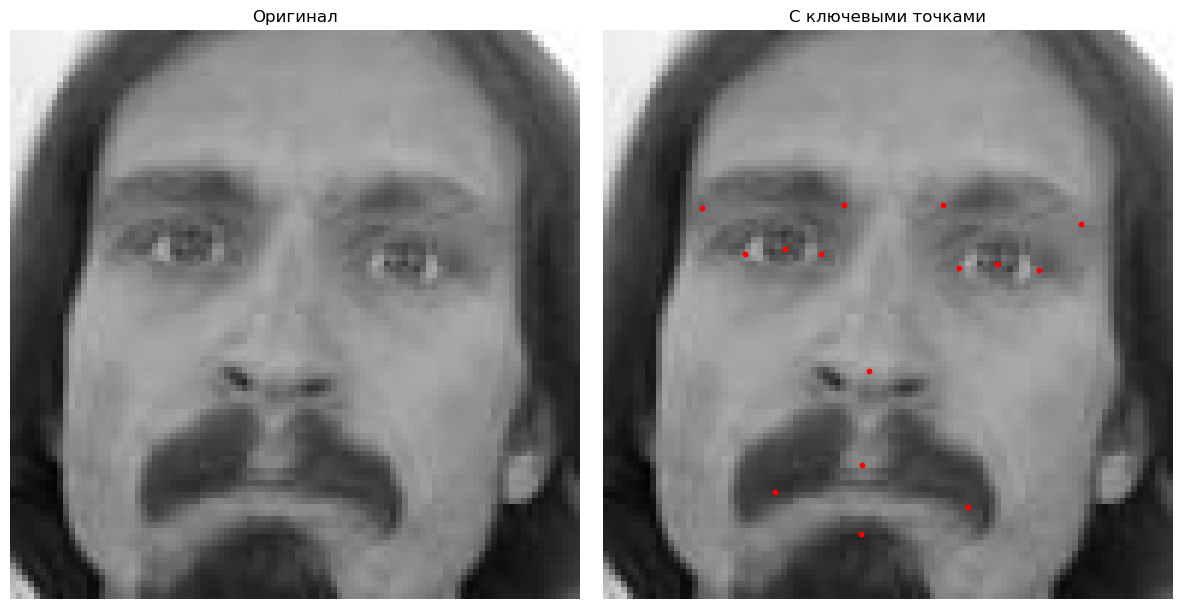

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def img_show(idx=0):
    # Загрузка аннотаций с учетом, что первая строка — заголовки
    df = pd.read_csv('dataset_1/training.csv')

    # Формируем имя файла изображения по индексу (например, '0.jpg', '1.jpg' и т.д.)
    image_name = f"{idx}.jpg"
    image_path = os.path.join('dataset_1/images', image_name)

    # Загружаем изображение через PIL
    image = np.array(Image.open(image_path).convert('RGB'))

    # Получаем координаты ключевых точек для данного индекса
    keypoint_cols = df.columns.tolist()
    keypoints = df.loc[idx, keypoint_cols].values.astype(float).reshape(-1, 2)

    # Создаем фигуру с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Слева — оригинальное изображение
    axs[0].imshow(image)
    axs[0].set_title('Оригинал')
    axs[0].axis('off')

    # Справа — изображение с наложенными ключевыми точками
    axs[1].imshow(image)
    axs[1].scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
    axs[1].set_title('С ключевыми точками')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

img_show(idx=0)

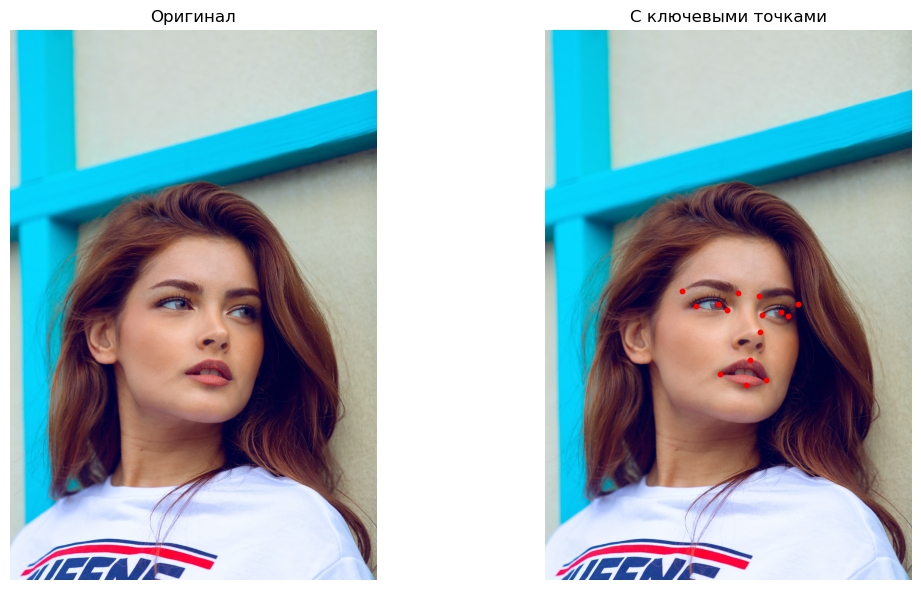

In [12]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def img_show(image_idx=0):
    # Парсинг XML
    tree = ET.parse('dataset_2/annotations.xml')
    root = tree.getroot()
    
    # Получаем нужный image-элемент по индексу
    image_elements = root.findall('image')
    image_elem = image_elements[image_idx]
    image_name = image_elem.attrib['name']  # например, 'FKP/1.jpg'
    image_path = os.path.join('dataset_2/images', os.path.basename(image_name))
    
    # Загружаем изображение
    image = np.array(Image.open(image_path).convert('RGB'))
    
    # Получаем ключевые точки
    keypoints = []
    for point_elem in image_elem.findall('points'):
        coords = point_elem.attrib['points'].split(',')
        x, y = float(coords[0]), float(coords[1])
        keypoints.append((x, y))
    keypoints = np.array(keypoints)
    
    # Визуализация
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title('Оригинал')
    axs[0].axis('off')
    
    axs[1].imshow(image)
    if len(keypoints) > 0:
        axs[1].scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
    axs[1].set_title('С ключевыми точками')
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

img_show(0)

In [14]:
import xml.etree.ElementTree as ET
import pandas as pd

rows = []
tree = ET.parse('dataset_2/annotations.xml')
root = tree.getroot()

for image_elem in root.findall('image'):
    image_name = image_elem.attrib['name']
    keypoints = []
    for point_elem in image_elem.findall('points'):
        coords = point_elem.attrib['points'].split(',')
        keypoints.extend([float(coords[0]), float(coords[1])])
    row = [image_name] + keypoints
    rows.append(row)

# Определяем максимальное количество точек (чтобы все строки были одинаковой длины)
max_points = max(len(r) for r in rows) - 1  # -1, потому что первый столбец — имя файла

# Формируем имена столбцов
columns = ['image_name']
for i in range(max_points // 2):
    columns += [f'keypoint_{i+1}_x', f'keypoint_{i+1}_y']

# Дополняем строки пустыми значениями, если точек меньше максимума
for row in rows:
    while len(row) < len(columns):
        row.append('')

df = pd.DataFrame(rows, columns=columns)
df.to_csv('dataset_2/annotations.csv', index=False)


In [22]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from shutil import move

# 1. Переименование изображений
image_folder = 'dataset_2/images'
image_files = sorted([f for f in os.listdir(image_folder) if f.lower().endswith('.jpg')])
old_to_new = {}

for idx, old_name in enumerate(image_files):
    new_name = f"{idx + 8000}.jpg"
    old_path = os.path.join(image_folder, old_name)
    new_path = os.path.join(image_folder, new_name)
    move(old_path, new_path)
    old_to_new[old_name] = new_name

# 2. Преобразование XML в CSV
tree = ET.parse('dataset_2/annotations.xml')
root = tree.getroot()
rows = []

for image_idx, image_elem in enumerate(root.findall('image')):
    old_image_name = os.path.basename(image_elem.attrib['name'])
    new_image_name = old_to_new[old_image_name]
    keypoints = []
    for point_elem in image_elem.findall('points'):
        coords = point_elem.attrib['points'].split(',')
        keypoints.extend([float(coords[0]), float(coords[1])])
    row = [new_image_name] + keypoints
    rows.append(row)

# Определяем максимальное количество точек
max_points = max(len(r) for r in rows) - 1
columns = ['image_name']
for i in range(max_points // 2):
    columns += [f'keypoint_{i+1}_x', f'keypoint_{i+1}_y']

# Дополняем строки пустыми значениями
for row in rows:
    while len(row) < len(columns):
        row.append('')

df = pd.DataFrame(rows, columns=columns)
df.to_csv('dataset_2/training_2.csv', index=False)


In [ ]:
import pandas as pd

# Загрузить исходный DataFrame
df = pd.read_csv('dataset_1/training.csv')

# Сформировать список имён файлов
image_names = [f"{i}.jpg" for i in range(len(df))]

# Вставить столбец 'image_name' в начало DataFrame
df.insert(0, 'image_name', image_names)  # loc=0 — вставка в начало[1][2][3][4][5]

# Сохранить результат
df.to_csv('dataset_1/training_1csv', index=False)


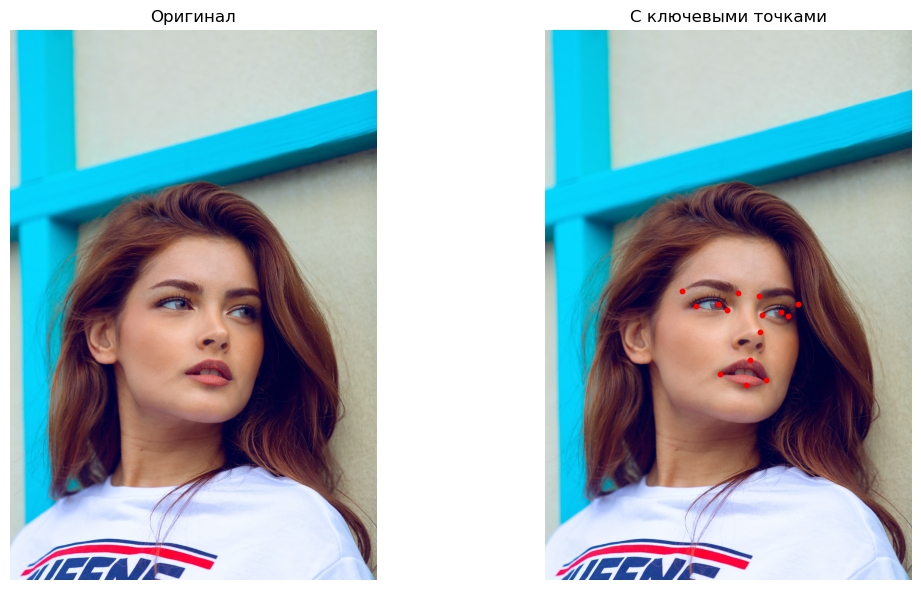

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def img_show(path_image='dataset_1/images', path_annotation='dataset_1/training_1.csv', idx=0):

    # Загрузка аннотаций
    df = pd.read_csv(path_annotation)

    # Получаем имя файла изображения из первого столбца
    image_name = df.loc[idx, 'image_name']
    image_path = os.path.join(path_image, image_name)

    # Загружаем изображение через PIL
    image = np.array(Image.open(image_path).convert('RGB'))

    # Получаем координаты ключевых точек (все столбцы, кроме image_name)
    keypoint_cols = [col for col in df.columns if col != 'image_name']
    keypoints = df.loc[idx, keypoint_cols].values.astype(float).reshape(-1, 2)

    # Создаем фигуру с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Слева — оригинальное изображение
    axs[0].imshow(image)
    axs[0].set_title('Оригинал')
    axs[0].axis('off')

    # Справа — изображение с наложенными ключевыми точками
    axs[1].imshow(image)
    axs[1].scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
    axs[1].set_title('С ключевыми точками')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

path_annotation='dataset_2/training_2.csv'
path_image='dataset_2/images'
img_show(path_image, path_annotation, 0)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

def img_show(path_img='dataset_2/images', path_annotation='dataset_2/training_2.csv', idx=0):
    # Загрузка аннотаций
    df = pd.read_csv(path_annotation)

    # Получаем имя файла изображения из первого столбца
    image_name = df.loc[idx, 'image_name']
    image_path = os.path.join(path_img, image_name)

    # Загружаем изображение через PIL
    image = np.array(Image.open(image_path).convert('RGB'))

    # Получаем координаты ключевых точек (все столбцы, кроме image_name)
    keypoint_cols = [col for col in df.columns if col != 'image_name']
    keypoints = df.loc[idx, keypoint_cols].values.astype(float).reshape(-1, 2)

    # Создаем фигуру с двумя подграфиками
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Слева — оригинальное изображение
    axs[0].imshow(image)
    axs[0].set_title('Оригинал')
    axs[0].axis('off')

    # Справа — изображение с наложенными ключевыми точками
    axs[1].imshow(image)
    axs[1].scatter(keypoints[:, 0], keypoints[:, 1], c='r', s=10)
    axs[1].set_title('С ключевыми точками')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()


img_show(0)